In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.ensemble import VotingClassifier

Using TensorFlow backend.


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cancer-diagnosis/training_text
/kaggle/input/cancer-diagnosis/training_variants
/kaggle/input/cancertreatment/stage2_test_text.csv
/kaggle/input/cancertreatment/test_variants
/kaggle/input/cancertreatment/test_text
/kaggle/input/cancertreatment/stage_2_private_solution.csv
/kaggle/input/cancertreatment/stage2_sample_submission.csv
/kaggle/input/cancertreatment/stage2_test_variants.csv
/kaggle/input/cancertreatment/stage1_solution_filtered.csv


In [3]:
training_text = pd.read_csv("../input/cancer-diagnosis/training_text",sep="\|\|", header=None, skiprows=1, names=["ID","Text"])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [4]:
training_text.head(5)

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [5]:
training_text.shape

(3321, 2)

In [6]:
training_variants = pd.read_csv("../input/cancer-diagnosis/training_variants")

In [7]:
training_variants.head(5)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [8]:
training_variants.shape

(3321, 4)

In [9]:
#Merging variants and text on ID

In [10]:
training_merge = training_variants.merge(training_text,left_on="ID",right_on="ID")

In [11]:
training_merge.head(5)
#Now we have the data

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [12]:
training_merge.shape

(3321, 5)

In [13]:
test_text = pd.read_csv("../input/cancertreatment/stage2_test_text.csv",sep="\|\|", header=None, skiprows=1, names=["ID","Text"])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [14]:
test_text.shape

(986, 2)

In [15]:
test_variants = pd.read_csv("../input/cancertreatment/stage2_test_variants.csv")

In [16]:
test_variants.shape

(986, 3)

In [17]:
test_merge = test_variants.merge(test_text,left_on="ID",right_on="ID")

In [18]:
# Let's understand the type of values present in each column of our dataframe 'train_merge' dataframe.
test_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 986 entries, 0 to 985
Data columns (total 4 columns):
ID           986 non-null int64
Gene         986 non-null object
Variation    986 non-null object
Text         986 non-null object
dtypes: int64(1), object(3)
memory usage: 38.5+ KB


In [19]:
training_merge.describe(include='all')

,ID,Gene,Variation,Class,Text
count,3321.000000,3321,3321,3321.000000,3316
unique,NaN,264,2996,NaN,1920
top,NaN,BRCA1,Truncating Mutations,NaN,The PTEN (phosphatase and tensin homolog) phos...
freq,NaN,264,93,NaN,53
mean,1660.000000,NaN,NaN,4.365854,NaN
std,958.834449,NaN,NaN,2.309781,NaN
min,0.000000,NaN,NaN,1.000000,NaN
25%,830.000000,NaN,NaN,2.000000,NaN
50%,1660.000000,NaN,NaN,4.000000,NaN
75%,2490.000000,NaN,NaN,7.000000,NaN


In [20]:
training_merge.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
Text         5
dtype: int64

In [21]:
training_merge.columns

Index(['ID', 'Gene', 'Variation', 'Class', 'Text'], dtype='object')

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

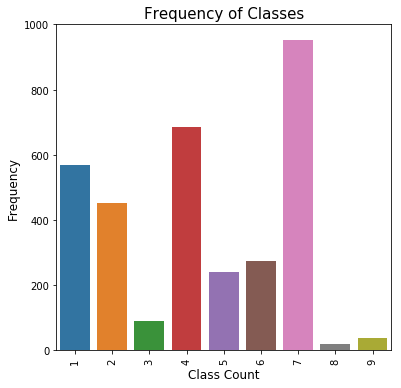

In [23]:
#Plot to see how classes are distributed
plt.figure(figsize=(6,6))
sns.countplot(x="Class", data=training_merge)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Class Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Classes", fontsize=15)
plt.show()

In [24]:
training_merge["Text_num_words"] = training_merge["Text"].apply(lambda x: len(str(x).split()) )
training_merge["Text_num_chars"] = training_merge["Text"].apply(lambda x: len(str(x)) )

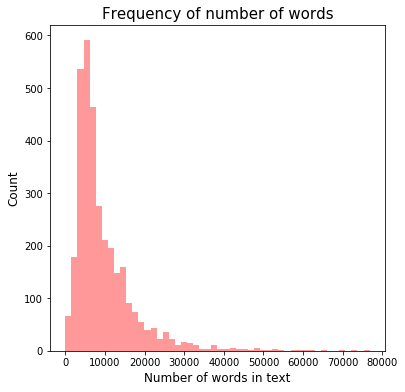

In [25]:
plt.figure(figsize=(6, 6))
sns.distplot(training_merge.Text_num_words.values, bins=50, kde=False, color='red')
plt.xlabel('Number of words in text', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("Frequency of number of words", fontsize=15)
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
sns.distplot(training_merge.Text_num_chars.values, bins=50, kde=False, color='brown')
plt.xlabel('Number of characters in text', fontsize=12)
plt.ylabel('log of Count', fontsize=12)
plt.title("Frequency of Number of characters", fontsize=15)
plt.show()

In [ ]:
train_genes = training_merge.groupby('Gene')['Gene'].count()

for i in [2, 5, 10, 20, 50, 100, 300]:
    print('Genes that appear less than {} times: {}%'.format(i, round((train_genes < i).mean() * 100, 2)))

In [ ]:
training_merge['Variation'].describe()

In [ ]:
training_merge['Gene'].describe()

In [ ]:
from wordcloud import WordCloud
cloud = WordCloud(width=1000, height=800).generate(" ".join(training_merge[training_merge.Class == 2]['Text']))
plt.figure(figsize=(10, 10))
plt.imshow(cloud)
plt.axis('off')
ax = plt.axes()

In [ ]:
from wordcloud import WordCloud
cloud = WordCloud(width=1000, height=800).generate(" ".join(training_merge[training_merge.Class == 3]['Text']))
plt.figure(figsize=(10, 10))
plt.imshow(cloud)
plt.axis('off')
ax = plt.axes()

In [ ]:
from wordcloud import WordCloud
cloud = WordCloud(width=1000, height=800).generate(" ".join(training_merge[training_merge.Class == 4]['Text']))
plt.figure(figsize=(10, 10))
plt.imshow(cloud)
plt.axis('off')
ax = plt.axes()


In [ ]:
from wordcloud import WordCloud
cloud = WordCloud(width=1000, height=800).generate(" ".join(training_merge[training_merge.Class == 5]['Text']))
plt.figure(figsize=(10, 10))
plt.imshow(cloud)
plt.axis('off')
ax = plt.axes()

In [ ]:
from wordcloud import WordCloud
cloud = WordCloud(width=1000, height=800).generate(" ".join(training_merge[training_merge.Class == 8]['Text']))
plt.figure(figsize=(10, 10))
plt.imshow(cloud)
plt.axis('off')
ax = plt.axes()
ax.set_title('Class 2 Text Word Cloud')

In [ ]:
for i in range(1, 9):
    classs = training_merge.loc[training_merge['Class'] == i]

    cnt_genes = classs.Gene.value_counts().reset_index()
    cnt_genes.columns = ['Gene', 'Count']
    
    total = cnt_genes.Count.sum()
    
    cnt_genes['Percentage'] = (cnt_genes.Count/total)*100
    cnt_genes.plot(x='Gene', y='Percentage', kind='bar', figsize=(20,4))

In [ ]:
cnt_genes.head()

In [ ]:
cnt_genes.describe

In [ ]:
s = training_merge.Gene.value_counts().reset_index()
s.columns=['Gene', 'Count']

In [ ]:
cnt = s.Count.value_counts().reset_index()
cnt.columns = ['Occurence', 'Count']
total = cnt.Count.sum()

In [ ]:
s.loc[s['Count'] > 25].plot(x='Gene', y='Count', kind='bar', figsize=(16, 6))

In [26]:
from collections import Counter
# Import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
# Import word_tokenize
from nltk.tokenize import word_tokenize
# Import stopwords
from nltk.corpus import stopwords
# Import string
import string
#Importing 

In [27]:
#Tokenzing-splitting up a larger body of text into smaller lines, words or even creating words 

In [28]:
#imputing gene row value to null data of text rows as for all other columns, Gene values are present in Text data
training_merge['Text'] = training_merge.apply(lambda row: row['Gene'] if pd.isnull(row['Text']) else row['Text'],axis=1)

In [29]:
training_merge.isnull().sum()

ID                0
Gene              0
Variation         0
Class             0
Text              0
Text_num_words    0
Text_num_chars    0
dtype: int64

In [30]:
#imputing gene row value to null data of text rows as for all other columns, Gene values are present in Text data
test_merge['Text'] = test_merge.apply(lambda row: row['Gene'] if pd.isnull(row['Text']) else row['Text'],axis=1)

In [31]:
mincl=[3,5,6,8,9]
maxcl=[1,2,4,7]

In [32]:
dfA=training_merge[training_merge['Class'].isin(mincl)]
dfB=training_merge[training_merge['Class'].isin(maxcl)]

In [33]:
dfA.head(5)

,ID,Gene,Variation,Class,Text,Text_num_words,Text_num_chars
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,5572,36238
6,6,CBL,V430M,5,Oncogenic mutations in the monomeric Casitas B...,6202,41308
14,14,CBL,P428L,5,Oncogenic mutations in the monomeric Casitas B...,6202,41308
18,18,CBL,M374V,5,Oncogenic mutations in the monomeric Casitas B...,6202,41308
20,20,CBL,H94Y,6,Abstract Background Non-small cell lung canc...,11958,78000


In [34]:
dfA.describe()

,ID,Class,Text_num_words,Text_num_chars
count,662.000000,662.000000,662.000000,662.000000
mean,1957.531722,5.456193,7666.942598,50961.948640
std,874.612086,1.378586,4694.537482,31233.168057
min,3.000000,3.000000,1.000000,3.000000
25%,1311.500000,5.000000,4951.750000,33028.000000
50%,2289.000000,5.500000,6463.000000,43019.000000
75%,2664.500000,6.000000,8812.000000,58319.000000
max,3314.000000,9.000000,45177.000000,297907.000000


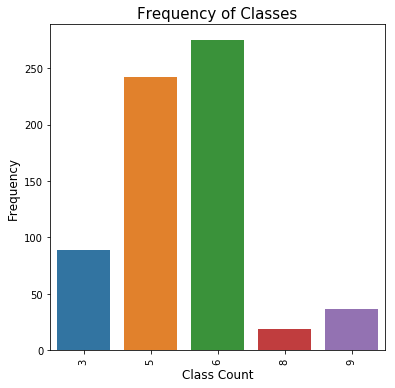

In [35]:
#Plot to see how classes are distributed
plt.figure(figsize=(6,6))
sns.countplot(x="Class", data=dfA)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Class Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Classes", fontsize=15)
plt.show()

In [36]:
dfB.describe()

,ID,Class,Text_num_words,Text_num_chars
count,2659.000000,2659.000000,2659.000000,2659.000000
mean,1585.924784,4.094396,10020.205716,66766.388116
std,964.662185,2.412760,8388.648466,55764.626380
min,0.000000,1.000000,1.000000,3.000000
25%,748.500000,2.000000,4715.000000,31199.500000
50%,1545.000000,4.000000,7082.000000,46804.000000
75%,2331.500000,7.000000,12935.000000,85401.500000
max,3320.000000,7.000000,76782.000000,523393.000000


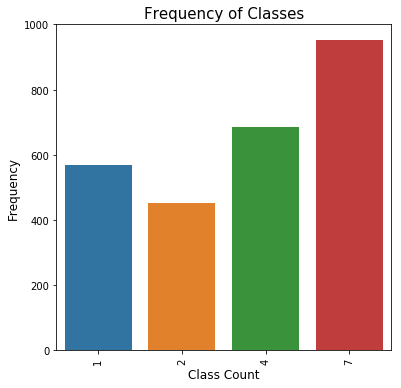

In [37]:
#Plot to see how classes are distributed
plt.figure(figsize=(6,6))
sns.countplot(x="Class", data=dfB)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Class Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Classes", fontsize=15)
plt.show()

In [38]:
#taking class column as dependent variable ie which needs to be find out from all other columns in our data
ym=training_merge.Class
yA=dfA.Class
yB=dfB.Class

In [39]:
X_A=dfA[["Text","Variation","Gene"]]
X_B=dfB[["Text","Variation","Gene"]]
X_m=training_merge[["Text","Variation","Gene"]]

In [40]:
X_A.head()

,Text,Variation,Gene
3,Recent evidence has demonstrated that acquired...,N454D,CBL
6,Oncogenic mutations in the monomeric Casitas B...,V430M,CBL
14,Oncogenic mutations in the monomeric Casitas B...,P428L,CBL
18,Oncogenic mutations in the monomeric Casitas B...,M374V,CBL
20,Abstract Background Non-small cell lung canc...,H94Y,CBL


In [41]:
X_B.head()

,Text,Variation,Gene
0,Cyclin-dependent kinases (CDKs) regulate a var...,Truncating Mutations,FAM58A
1,Abstract Background Non-small cell lung canc...,W802*,CBL
2,Abstract Background Non-small cell lung canc...,Q249E,CBL
4,Oncogenic mutations in the monomeric Casitas B...,L399V,CBL
5,Oncogenic mutations in the monomeric Casitas B...,V391I,CBL


In [42]:
# Definig vectorizing object for Text column
vect_text= CountVectorizer(stop_words ='english')

#Defining vectorizing object for Variation column
vect_variation= CountVectorizer(stop_words ='english')

##Defining vectorizing object for Gene column
gene_variation= CountVectorizer(stop_words ='english')

In [43]:
#vectorizing  for Text column which gives the count of repeated words for each row for both the dataframes
vect_text.fit(X_A["Text"])
vect_text.fit(X_B["Text"])
vect_text.fit(X_m["Text"])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [44]:
#vectorizing for Variation column  which gives the count of repeated words for each row
vect_variation.fit(X_A["Variation"])
vect_variation.fit(X_B["Variation"])
vect_variation.fit(X_m["Variation"])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [45]:
gene_variation.fit(X_A["Gene"])
gene_variation.fit(X_B["Gene"])
gene_variation.fit(X_m["Gene"])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [46]:
len(vect_text.vocabulary_)

155436

In [ ]:
len(vect_variation.vocabulary_)

In [ ]:
len(gene_variation.vocabulary_)

In [ ]:
vect_text.vocabulary_

In [ ]:
vect_variation.vocabulary_

In [ ]:
gene_variation.vocabulary_

In [47]:
#transforming count of Variation words in to matrix
variation_tranform_train_A=vect_variation.transform(X_A["Variation"])
variation_tranform_train_B=vect_variation.transform(X_B["Variation"])
variation_tranform_train_m=vect_variation.transform(X_m["Variation"])

In [48]:
#transforming count of Text words in to matrix
text_transformed_train_A= vect_text.transform(X_A["Text"])
text_transformed_train_B= vect_text.transform(X_B["Text"])
text_transformed_train_m= vect_text.transform(X_m["Text"])

In [49]:
#transforming count of gene words in to matrix
gene_transformed_train_A= gene_variation.transform(X_A["Gene"])
gene_transformed_train_B= gene_variation.transform(X_B["Gene"])
gene_transformed_train_m= gene_variation.transform(X_m["Gene"])

In [50]:
#merging train data of two Matrix horixzontally to train the model
import scipy.sparse as sp
XA_final = sp.hstack((variation_tranform_train_A,text_transformed_train_A,gene_transformed_train_A))
XB_final = sp.hstack((variation_tranform_train_B,text_transformed_train_B,gene_transformed_train_B))
Xm_final = sp.hstack((variation_tranform_train_m,text_transformed_train_m,gene_transformed_train_m))

In [ ]:
XA_final.shape

In [ ]:
XB_final.shape

In [ ]:
yA.shape

In [ ]:
yB.shape

In [ ]:
Xm_final.shape

In [ ]:
ym.shape

In [51]:
# splitting into test and train
from sklearn.model_selection  import train_test_split
from imblearn.over_sampling import SMOTE
XA_train, XA_test, yA_train, yA_test = train_test_split(XA_final, yA, random_state=1)

In [52]:
XB_train, XB_test, yB_train, yB_test = train_test_split(XB_final, yB, random_state=1)

In [53]:
print(XA_train.shape)

(496, 158717)


In [55]:
print(yA_train.shape)

(496,)


In [56]:
print(XA_test.shape)

(166, 158717)


In [57]:
print(yA_test.shape)

(166,)


In [58]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report 
# Model Generation Using Multinomial Naive Bayes
clfA = MultinomialNB().fit(XA_train, yA_train)
predicted= clfA.predict(XA_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(yA_test, predicted))
print(classification_report(yA_test,predicted))

MultinomialNB Accuracy: 0.7590361445783133
              precision    recall  f1-score   support

           3       0.86      0.60      0.71        20
           5       0.68      0.78      0.72        54
           6       0.83      0.82      0.83        78
           8       0.50      0.20      0.29         5
           9       0.64      0.78      0.70         9

    accuracy                           0.76       166
   macro avg       0.70      0.64      0.65       166
weighted avg       0.76      0.76      0.76       166



In [59]:
# Model Generation Using Multinomial Naive Bayes
clfB = MultinomialNB().fit(XB_train, yB_train)
predicted= clfB.predict(XB_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(yB_test, predicted))
print(classification_report(yB_test,predicted))

MultinomialNB Accuracy: 0.6827067669172933
              precision    recall  f1-score   support

           1       0.61      0.71      0.66       140
           2       0.50      0.52      0.51       117
           4       0.79      0.65      0.71       175
           7       0.76      0.77      0.76       233

    accuracy                           0.68       665
   macro avg       0.67      0.66      0.66       665
weighted avg       0.69      0.68      0.68       665



In [60]:
from sklearn.ensemble import VotingClassifier

In [61]:
#Using Average weighting on the models that we have generated
#Using a voting classifier on Multinomial NB after hyperparameter tuning would be a waste as it NB is a pretty simple Model

In [62]:
Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm_final, ym, random_state=1)

In [63]:
# Model Generation Using Multinomial Naive Bayes
clfm = MultinomialNB().fit(Xm_train, ym_train)
predict= clfm.predict(Xm_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(ym_test, predict))
print(classification_report(ym_test,predict))

MultinomialNB Accuracy: 0.5812274368231047
              precision    recall  f1-score   support

           1       0.50      0.61      0.55       142
           2       0.41      0.46      0.44       117
           3       0.50      0.26      0.34        27
           4       0.77      0.54      0.63       170
           5       0.33      0.48      0.39        50
           6       0.73      0.57      0.64        61
           7       0.67      0.70      0.69       250
           8       1.00      0.20      0.33         5
           9       0.73      0.89      0.80         9

    accuracy                           0.58       831
   macro avg       0.63      0.52      0.54       831
weighted avg       0.61      0.58      0.58       831



In [74]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
#We see that the accuracy is skewed for the entire model as the data is imbalanced as we saw in the class distribution

In [ ]:
#We would now try to tune the SVM hyperparameters and stack the classifiers built from them to be able to aid out 
#our final machine learning model

In [ ]:
#Tuning the hyperparameters for the minority data

In [84]:
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1], #10, 100, 1000],  
              'gamma': [1, 0.1, 0.01], #0.001, 0.0001], 
              'kernel': ['linear']}  
  
gridA = GridSearchCV(SVC(probability=True), param_grid, refit = True, verbose = 3,) 
  
# fitting the model for grid search 
gridA.fit(XA_train, yA_train) 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.665, total=  12.2s
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.2s remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.651, total=  11.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.1s remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.718, total=  12.3s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.665, total=  11.7s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.651, total=  10.2s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.718, total=  12.1s
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV] .... C=0.1, gamma=0.01, kernel=linear, score=0.665, total=  11.6s
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV] .... C=0.1, gamma=0.01, kernel=linear, score=0.651, total=  10.5s
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV] .... C=0.1, gamma=0.01, kernel=linear, score=0.718, total=  12.8s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  3.6min finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [85]:
# print best parameter after tuning 
print(gridA.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(gridA.best_estimator_) 

{'C': 1, 'gamma': 1, 'kernel': 'linear'}
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [86]:
gridA_predictions = gridA.predict(XA_test) 
  
# print classification report 
print(classification_report(yA_test, gridA_predictions)) 

              precision    recall  f1-score   support

           3       0.65      0.75      0.70        20
           5       0.78      0.72      0.75        54
           6       0.84      0.87      0.86        78
           8       0.60      0.60      0.60         5
           9       1.00      0.78      0.88         9

    accuracy                           0.80       166
   macro avg       0.77      0.74      0.76       166
weighted avg       0.80      0.80      0.80       166



In [87]:
# defining parameter range 
param_grid = {'C': [0.1, 1], #10, 100, 1000],  
              'gamma': [1],
              'kernel': ['linear']}  
gridB = GridSearchCV(SVC(probability=True), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
gridB.fit(XB_train, yB_train) 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.647, total= 2.0min
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.674, total= 2.1min
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.1min remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.673, total= 2.2min
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ......... C=1, gamma=1, kernel=linear, score=0.647, total= 2.3min
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ......... C=1, gamma=1, kernel=linear, score=0.684, total= 2.4min
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ......... C=1, gamma=1, kernel=linear, score=0.694, total= 2.5min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 13.4min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1], 'gamma': [1], 'kernel': ['linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [88]:
gridB_predictions = gridB.predict(XB_test) 
  
# print classification report 
print(classification_report(yB_test, gridB_predictions)) 

              precision    recall  f1-score   support

           1       0.63      0.65      0.64       140
           2       0.54      0.56      0.55       117
           4       0.73      0.71      0.72       175
           7       0.77      0.75      0.76       233

    accuracy                           0.68       665
   macro avg       0.67      0.67      0.67       665
weighted avg       0.69      0.68      0.69       665



In [89]:
eclf2 = VotingClassifier(estimators=[('svmA',gridA), ('svmB', gridB)], voting='soft')

In [90]:
# fitting the model for grid search 
eclf2.fit(Xm_train, ym_train) 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.571, total= 4.3min
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.561, total= 4.1min
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.4min remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.570, total= 4.3min
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.571, total= 4.4min
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.561, total= 4.0min
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.570, total= 4.4min
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV] .... C=0.1, gamma=0.01, kernel=linear, score=0.571, total= 4.3min
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV] .... C=0.1, gamma=0.01, kernel=linear, score=0.561, total= 4.1min
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV] .... C=0.1, gamma=0.01, kernel=linear, score=0.570, total= 4.3min
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 78.4min finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.571, total= 4.3min
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.561, total= 3.9min
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.2min remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.570, total= 4.2min
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ......... C=1, gamma=1, kernel=linear, score=0.580, total= 4.8min
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ......... C=1, gamma=1, kernel=linear, score=0.564, total= 4.2min
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ......... C=1, gamma=1, kernel=linear, score=0.577, total= 4.5min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 25.9min finished


VotingClassifier(estimators=[('svmA',
                              GridSearchCV(cv='warn',
                                           error_score='raise-deprecating',
                                           estimator=SVC(C=1.0, cache_size=200,
                                                         class_weight=None,
                                                         coef0=0.0,
                                                         decision_function_shape='ovr',
                                                         degree=3,
                                                         gamma='auto_deprecated',
                                                         kernel='rbf',
                                                         max_iter=-1,
                                                         probability=True,
                                                         random_state=None,
                                                         shrinking=True,
      

In [ ]:
#eclf2.probability = True

In [ ]:
ym_pred=eclf2.predict(Xm_test)

In [ ]:
print(classification_report(ym_test, ym_pred))

In [ ]:
for i in range(1,9):
    print("Before SMOTE, counts of label {}: {}".format(i,sum(ym_train == i))) 
 
# apply near miss 
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2) 
  
X_train_miss, y_train_miss = sm.fit_sample(Xm_train, ym_train.ravel()) 
  
print('After SMOTE, the shape of train_X:{}'.format(Xm_train_miss.shape)) 
print('After SMOTE, the shape of train_y: {} \n'.format(ym_train_miss.shape)) 

for i in range(1,9):
    print("After SMOTE, counts of label {}: {}".format(i,sum(ym_train_miss == i))) 

In [ ]:
#Hyperparameter tuning for Random Forest

In [ ]:
alpha = [100,200]
         #500,1000,2000]
max_depth = [5, 10]
val_log_loss_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42)
        clf.fit(X_train_miss, y_train_miss)
        calib_clf = CalibratedClassifierCV(clf, method="sigmoid")
        calib_clf.fit(X_train_miss, y_train_miss)
        calib_clf_probs = calib_clf.predict_proba(X_test)
        val_log_loss_array.append(log_loss(y_test,calib_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_test,calib_clf_probs)) 

best_alpha = np.argmin(val_log_loss_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42)
clf.fit(X_train_miss,y_train_miss)
calib_clf = CalibratedClassifierCV(clf, method="sigmoid")
calib_clf.fit(X_train_miss, y_train_miss)

In [ ]:
ran_clf=RandomForestClassifier(bootstrap=True,
                                                             class_weight=None,
                                                             criterion='gini',
                                                             max_depth=10,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1,
                                                             min_samples_split=2,
                                                             min_weight_fraction_leaf=0.0,
                                                             n_estimators=200,
                                                             n_jobs=None,
                                                             oob_score=False,
                                                             random_state=42,
                                                             verbose=0,
                                                             warm_start=False)

In [ ]:
ran_clf.fit(XA_train,yA_train_miss)
y_pred=ran_clf.predict(XA_test)
print(classification_report(yA_test,yA_pred))

In [ ]:
voting_clf = VotingClassifier([('svc', svm.SVC(probability=True)),
                            ('nsb', MultinomialNB()),
                            ('rfor', RandomForestClassifier())],voting='soft')

In [ ]:
voting_clf.fit(X_train_miss, y_train_miss)

In [ ]:
y_pred_class=voting_clf.predict_proba(X_test)
#classification_report(y_test, y_pred_class)

In [ ]:
y_pred_class

In [ ]:
y_sub=pd.DataFrame(y_pred_class)

In [ ]:
y_sub.head(5)

In [ ]:
classes = "class1,class2,class3,class4,class5,class6,class7,class8,class9".split(',')

In [ ]:
subm = pd.DataFrame(y_pred_class, columns=classes)

In [ ]:
subm['ID'] =subm.index

In [ ]:
subm.head(3)

In [ ]:
subm.to_csv('stacking.csv', index=False)

 **Using TF-IDF**

In [ ]:
tf=TfidfVectorizer()
text_tf= tf.fit_transform(training_merge['Text'])

In [ ]:
text_tf

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    text_tf, training_merge['Class'], test_size=0.3, random_state=123)

In [ ]:
X_train.shape

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report 
# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))
print(classification_report(y_test,predicted))

In [ ]:
#Trying to handle imbalanced data

In [ ]:
#SMOTE

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report 
# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train_miss, y_train_miss)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))
print(classification_report(y_test,predicted))

In [ ]:
#USING SMOTE

In [ ]:
for i in range(1,9):
    print("Before SMOTE, counts of label {}: {}".format(i,sum(y_train == i))) 
 
# apply near miss 
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2) 
  
X_train_miss, y_train_miss = sm.fit_sample(X_train, y_train.ravel()) 
  
print('After SMOTE, the shape of train_X:{}'.format(X_train_miss.shape)) 
print('After SMOTE, the shape of train_y: {} \n'.format(y_train_miss.shape)) 

for i in range(1,9):
    print("After SMOTE, counts of label {}: {}".format(i,sum(y_train_miss == i))) 

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report 
# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train_miss, y_train_miss)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))
print(classification_report(y_test,predicted))

In [ ]:
#ACCURACY DOES BETTER WITH SMOTE SO WE WILL USE SMOTE

In [ ]:
# Let's run Linear SVM model using the selected variables
from sklearn import metrics
from sklearn import svm
from sklearn.metrics import classification_report
svc_model=svm.LinearSVC()
svc_model.fit(X_train_miss,y_train_miss)

#predicting the Test data using our trained Linear SVM model
y_pred_class = svc_model.predict(X_test)

print(classification_report(y_test, y_pred_class))